<a href="https://colab.research.google.com/github/faridrizqi46/Time-Series/blob/main/Forecasting_FBProphet%2CArima%2CLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import numpy as np
import pandas as pd
import requests
import datetime

In [ ]:
pd.options.display.float_format = '{: .2f}'.format

In [ ]:
def get_json(api_url):
	response = requests.get(api_url)
	if response.status_code == 200:
		return json.loads(response.content.decode('utf-8'))
	else:
		return None

In [ ]:
covid_url = 'https://covid19-api.org/api/timeline'
'https://covidtracking.com/api/states/daily'

In [ ]:
#covid_url = 'https://covid19-api.org/api/timeline/ID'
#df = pd.json_normalize(get_json(covid_url))
df = pd.read_json('/content/Indonesia.JSON')

print(df.head())

     Country CountryCode Province  ... Cases     Status                      Date
0  Indonesia          ID           ...     0  confirmed 2020-03-01 00:00:00+00:00
1  Indonesia          ID           ...     2  confirmed 2020-03-02 00:00:00+00:00
2  Indonesia          ID           ...     2  confirmed 2020-03-03 00:00:00+00:00
3  Indonesia          ID           ...     2  confirmed 2020-03-04 00:00:00+00:00
4  Indonesia          ID           ...     2  confirmed 2020-03-05 00:00:00+00:00

[5 rows x 10 columns]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   Country      276 non-null    object             
 1   CountryCode  276 non-null    object             
 2   Province     276 non-null    object             
 3   City         276 non-null    object             
 4   CityCode     276 non-null    object             
 5   Lat          276 non-null    float64            
 6   Lon          276 non-null    float64            
 7   Cases        276 non-null    int64              
 8   Status       276 non-null    object             
 9   Date         276 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(6)
memory usage: 21.7+ KB


In [ ]:
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [ ]:
df.head()

,Country,CountryCode,Province,City,CityCode,Lat,Lon,Cases,Status,Date
0,Indonesia,ID,,,,-0.79,113.92,0,confirmed,2020-03-01
1,Indonesia,ID,,,,-0.79,113.92,2,confirmed,2020-03-02
2,Indonesia,ID,,,,-0.79,113.92,2,confirmed,2020-03-03
3,Indonesia,ID,,,,-0.79,113.92,2,confirmed,2020-03-04
4,Indonesia,ID,,,,-0.79,113.92,2,confirmed,2020-03-05


In [ ]:
df.isnull().sum()

Country        0
CountryCode    0
Province       0
City           0
CityCode       0
Lat            0
Lon            0
Cases          0
Status         0
Date           0
dtype: int64

In [ ]:
total_case = df[['Date','Cases']]

In [ ]:
total_case = total_case.sort_values(by='Date').reset_index(drop=True)

In [ ]:
total_case

,Date,Cases
0,2020-03-01,0
1,2020-03-02,2
2,2020-03-03,2
3,2020-03-04,2
4,2020-03-05,2
...,...,...
271,2020-11-27,522581
272,2020-11-28,527999
273,2020-11-29,534266
274,2020-11-30,538883


In [ ]:
total_case['Date'] = pd.to_datetime(total_case['Date'])

# FB Prophet

In [ ]:
from fbprophet import Prophet

In [ ]:
total_case1 = total_case.copy()

In [ ]:
total_case1.columns=['ds','y']

In [ ]:
model = Prophet(interval_width=0.95)
model.fit(total_case1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = model.make_future_dataframe(periods=80)

In [ ]:
forecast_conf = model.predict(future)

In [ ]:
forecast_conf.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
351,2021-02-15,835198.29,780161.09,887655.93,779689.54,890783.26,-23.15,-23.15,-23.15,-23.15,-23.15,-23.15,0.00,0.00,0.00,835175.14
352,2021-02-16,839165.33,781978.82,895124.96,782306.64,895302.21,-96.88,-96.88,-96.88,-96.88,-96.88,-96.88,0.00,0.00,0.00,839068.44
353,2021-02-17,843132.36,784853.80,899747.38,785361.25,899802.73,-284.18,-284.18,-284.18,-284.18,-284.18,-284.18,0.00,0.00,0.00,842848.19
354,2021-02-18,847099.40,788622.41,902856.21,788720.25,904329.23,-95.78,-95.78,-95.78,-95.78,-95.78,-95.78,0.00,0.00,0.00,847003.62
355,2021-02-19,851066.44,792046.98,910017.22,791842.08,908932.38,61.36,61.36,61.36,61.36,61.36,61.36,0.00,0.00,0.00,851127.80


In [ ]:
forecast_conf[['ds','yhat','yhat_lower','yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
391,2021-02-16,112476094.65,111711306.88,113351286.77
392,2021-02-17,113109871.91,112350448.96,113853468.05
393,2021-02-18,113762506.21,113006334.50,114493509.84
394,2021-02-19,114399415.24,113609553.10,115160949.78
395,2021-02-20,115025022.62,114276198.07,115858743.28


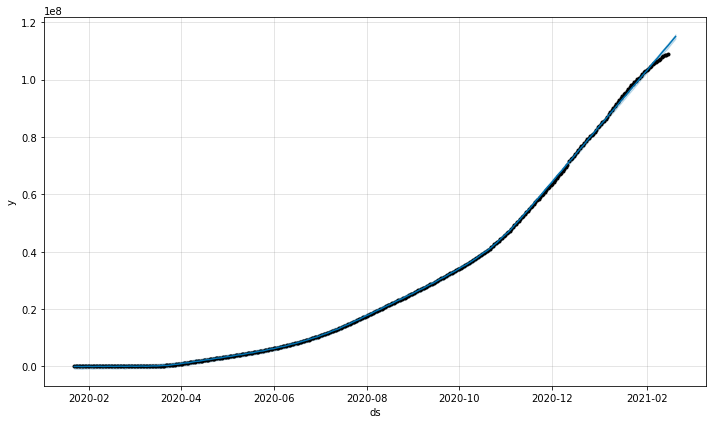

In [ ]:
forecast_conf_plot = model.plot(forecast_conf)

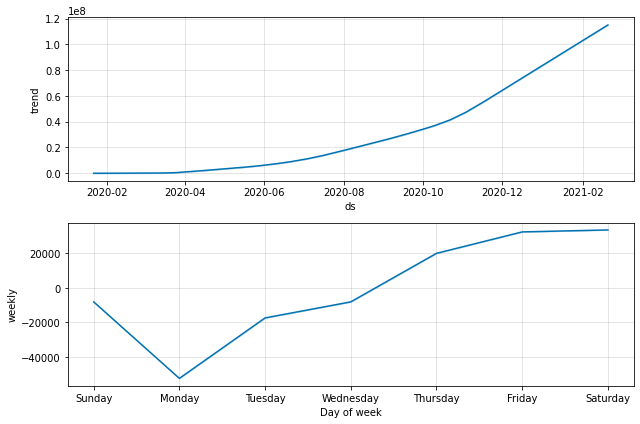

In [ ]:
conf_forecast_plot_component = model.plot_components(forecast_conf)

# Arima

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima import auto_arima

In [ ]:
total_case2 = total_case.copy()

In [ ]:
total_case2.set_index('last_update',inplace=True)

In [ ]:
total_case2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 391 entries, 2020-01-22 to 2021-02-15
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   total_cases  391 non-null    int64
dtypes: int64(1)
memory usage: 6.1 KB


In [ ]:
len(total_case2)

391

In [ ]:
train = total_case2[:350]
test = total_case2[350:]

In [ ]:
model = auto_arima(train,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=8770.444, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=8949.284, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=8854.827, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=8769.762, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=8771.583, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=8767.886, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=8768.737, Time=0.15 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=8768.956, Time=0.18 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=8760.286, Time=0.26 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=8763.824, Time=0.51 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=8756.348, Time=0.31 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=8758.681, Time=0.18 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=8726.091, Time=1.30 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=inf, Time=1.51 sec
 ARIMA(2,2,5)(0,0,0)[0]             : 

In [ ]:
model.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(2, 2, 4), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
forecast = model.predict(n_periods=len(test))

In [ ]:
forecast

array([8.68701543e+07, 8.75489318e+07, 8.82081883e+07, 8.88144084e+07,
       8.93742838e+07, 8.99295054e+07, 9.05251236e+07, 9.11754903e+07,
       9.18535280e+07, 9.25113496e+07, 9.31165265e+07, 9.36765375e+07,
       9.42329664e+07, 9.48299474e+07, 9.54808017e+07, 9.61580866e+07,
       9.68144887e+07, 9.74186546e+07, 9.79788256e+07, 9.85364602e+07,
       9.91347774e+07, 9.97860882e+07, 1.00462608e+08, 1.01117607e+08,
       1.01720793e+08, 1.02281148e+08, 1.02839986e+08, 1.03439613e+08,
       1.04091350e+08, 1.04767093e+08, 1.05420704e+08, 1.06022943e+08,
       1.06583505e+08, 1.07143543e+08, 1.07744453e+08, 1.08396586e+08,
       1.09071542e+08, 1.09723782e+08, 1.10325105e+08, 1.10885895e+08,
       1.11447130e+08])

In [ ]:
from matplotlib import pyplot


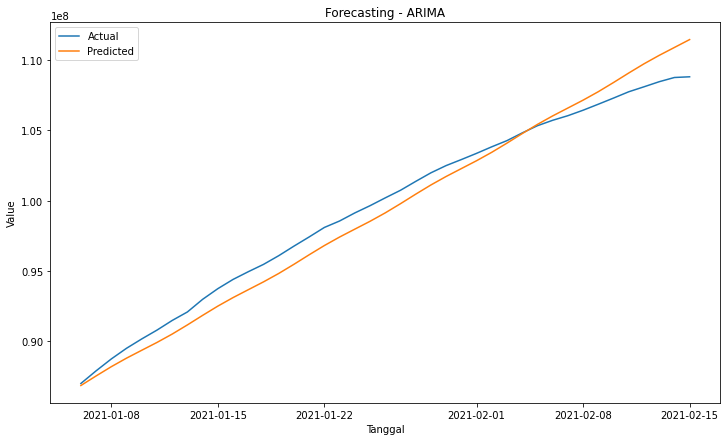

In [ ]:
# plot untuk mengilustrasikan perbedaan actual dan predicted price
pyplot.figure(figsize=(12,7));
pyplot.plot(test.index, test, label='Actual');
pyplot.plot(test.index, forecast, label='Predicted');
pyplot.title('Forecasting - ARIMA')
pyplot.xlabel('Tanggal')
pyplot.ylabel('Value')
pyplot.legend();

# LSTM

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
numpy.random.seed(48)

In [ ]:
X = total_case[['total_cases']]
X = X.values
X = X.astype('float32')

In [ ]:
X

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [ ]:
train_size = int(len(X) * 0.9)
test_size = len(X) - train_size
train, test = X[0:train_size,:], X[train_size:len(X),:]
print(len(train), len(test))

351 40


In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 357966.10 RMSE
Test Score: 2946132.95 RMSE


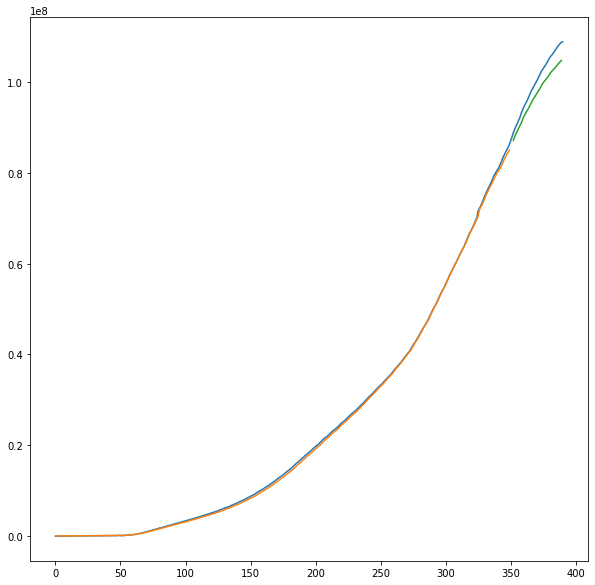

In [ ]:
plt.figure(figsize=(10,10))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(X)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(X)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(X)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(X))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()